# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
experiment_name = "general_dependency_logit_model"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/{experiment_name}"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()


# Loads dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Loads first-time contributor data frame.
print(f"{len(df)=}")
print(f"{len(df.columns)=}")

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]
independent_fields = [
    field
    for field in df.columns
    if (field not in metadata_fields and field not in dependent_fields)
]

df.describe()

len(df)=1216221
len(df.columns)=43


,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Feature selection for collaborative model

Identifies all features that are not part of the collaborative model and drops those.

In [2]:
# Identifies the to-be-dropped features

from python_proj.utils.util import get_matching

has_dependency_no_otheers_pattern = (
    r"^(?:(?!Dependency|Control|IntraProject(?!LinkIntensity|SecondOrder)|SubmitterIsFirstTimeContributor).)*$"
)
dropped_fields = list(
    get_matching(independent_fields, has_dependency_no_otheers_pattern)
)

print(f"{len(dropped_fields)=}")
print(f"{dropped_fields=}")

len(dropped_fields)=9
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)', 'ln(1 + IntraProjectLinkIntensity)']


In [3]:
# Drops the selected features

df = df.drop(dropped_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in dropped_fields
]

print(f"{len(df.columns)=}")
df.describe()

len(df.columns)=34


,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),...,ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,9.860918e-02,3.749753e-01,5.920373e-02,4.196918e-01,...,2.313934e-02,2.202497e-02,7.018853e-02,1.273611e-01,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,2.908001e-01,4.479160e-01,2.284681e-01,2.256422e-01,...,9.865160e-02,9.845844e-02,1.282197e-01,1.878345e-01,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.368024e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.434840e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,0.000000e+00,9.230769e-01,0.000000e+00,5.862811e-01,...,0.000000e+00,0.000000e+00,1.045989e-01,2.261884e-01,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Log-odds linearity


### Visual checking


untransformed


IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.500000
0.25    0.862069
0.40    0.954545
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.75, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.08350888149854074, 1.6126665000766334, 2.56093989695728, 2.557803963491896, 2.49508925157209, 2.49508925157209, 2.49508925157209, 2.49508925157209]


DependencyEcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.666667
0.25    0.909091
0.40    1.000000
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: DependencyEcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.4, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], y=[1.322472429049171, 2.2770608973097293, 2.5002153490111705, 2.4670588257088597, 2.4670588257088597, 2.4670588257088597, 2.4670588257088597, 2.4670588257088597]


NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.250000
0.25    0.714286
0.40    0.875000
0.50    0.938272
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.5, 0.8, 0.9090909090909092, 1.0, 1.0, 1.0, 1.0], y=[0.8541471461164114, 1.185906178137253, 1.7079191841349883, 2.1282137090706903, 1.8895612655397958, 1.7797650815004138, 1.7797650815004138, 1.7797650815004138]


InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.666667
0.25    0.875000
0.40    0.947712
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate, dtype: float64

x=[0.5, 0.8, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], y=[1.1030117678275946, 2.0830507232207536, 2.5797067136533056, 2.512549280598689, 2.451423208102506, 2.451423208102506, 2.451423208102506, 2.451423208102506]


ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.236802
0.50    0.443489
0.75    0.586287
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.1277870687664653, 0.3402738923454344, 0.5096383073097654, 0.6888808059305025], y=[1.899850992587973, 1.9012760002909048, 1.6054019300047595, 0.30682132073220164]


ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075257
0.25    0.075257
0.50    0.075257
0.75    0.150513
1.00    1.000000
Name: ln(1 + ControlNumberOfCommitsInPullRequest), dtype: float64

x=[0.0752566818678054, 0.0752566818678054, 0.0752566818678054, 0.1945357005569789], y=[1.2763498180485957, 1.2763498180485957, 1.3136880178407773, 1.3492120046982063]


ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator):
0.00    0.082914
0.25    0.192520
0.50    0.323936
0.75    0.452663
1.00    1.000000
Name: ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator), dtype: float64

x=[0.131415509494516, 0.2487418650625275, 0.3850404832422425, 0.5355770226879009], y=[0.8384402006683159, 1.2058967573246515, 1.7711423347783908, 2.4104578040157776]


ln(1 + IntraProjectSubmitterPullRequestSubmissionCount):
0.00    0.093185
0.25    0.147695
0.50    0.279556
0.75    0.402740
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterPullRequestSubmissionCount), dtype: float64

x=[0.0931851897337991, 0.1863703794675982, 0.3340654108182559, 0.4817604421689136], y=[1.397555357102435, 1.8401641906283608, 2.2390600315509404, 2.3840515803918714]


ln(1 + IntraProjectSubmitterPullRequestCommentCount):
0.00    0.091181
0.25    0.144518
0.50    0.273542
0.75    0.412462
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterPullRequestCommentCount), dtype: float64

x=[0.091180757686505, 0.2117151629854128, 0.3374088972733419, 0.5007513264263185], y=[1.6303076959413068, 1.8648725154216834, 2.1142644583091594, 2.0421818387594093]


ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount):
0.00    0.111899
0.25    0.111899
0.50    0.259821
0.75    0.401153
1.00    1.000000
Name: ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount), dtype: float64

x=[0.1118989050273207, 0.1773555683400614, 0.3141399418013053, 0.5130522834220237], y=[1.9927059302064154, 2.0958387273140358, 2.3923473663126855, 2.6457161448970647]


ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount):
0.00    0.111042
0.25    0.175997
0.50    0.257831
0.75    0.410903
1.00    1.000000
Name: ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount), dtype: float64

x=[0.1110417156008922, 0.2220834312017844, 0.3117335068458854, 0.5091221020458343], y=[2.0838767651318144, 2.123769090244927, 2.2602602070112576, 2.450061422315604]


ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount):
0.00    0.100170
0.25    0.158766
0.50    0.258937
0.75    0.425516
1.00    1.000000
Name: ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount), dtype: float64

x=[0.1001703539642537, 0.2003407079285075, 0.3327587131086662, 0.5366678806844908], y=[1.329873878323302, 1.4951487660319727, 1.7397164559499583, 2.073707720920167]


ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount):
0.00    0.096692
0.25    0.193385
0.50    0.306508
0.75    0.479033
1.00    1.000000
Name: ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount), dtype: float64

x=[0.1532538249434043, 0.2499462229488296, 0.3867695920217014, 0.5865447103401514], y=[1.438607209357225, 1.5765194163743386, 1.7425027324066444, 1.870489620563146]


ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount):
0.00    0.103144
0.25    0.163479
0.50    0.326957
0.75    0.478984
1.00    1.000000
Name: ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount), dtype: float64

x=[0.1031435227654369, 0.2394918433147222, 0.3927039990793467, 0.5729198616756545], y=[1.8030447836263974, 2.139109066746679, 2.389551399561132, 2.614908644142086]


ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount):
0.00    0.103732
0.25    0.207464
0.50    0.344590
0.75    0.498676
1.00    1.000000
Name: ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount), dtype: float64

x=[0.1644110197621435, 0.2681428239451047, 0.4149272167318449, 0.6024074035958356], y=[2.014225178140734, 2.1431037010888954, 2.3093788643872815, 2.411847612641944]


ln(1 + IntraProjectSubmitterIssueSubmissionCount):
0.00    0.104599
0.25    0.104599
0.50    0.165785
0.75    0.313797
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterIssueSubmissionCount), dtype: float64

x=[0.1045988688198613, 0.1045988688198613, 0.2091977376397226, 0.3982450180429566], y=[1.5130756278922541, 1.5943794314309285, 1.969050510361217, 2.2517654284101294]


ln(1 + IntraProjectSubmitterIssueCommentCount):
0.00    0.087502
0.25    0.175003
0.50    0.290674
0.75    0.433500
1.00    1.000000
Name: ln(1 + IntraProjectSubmitterIssueCommentCount), dtype: float64

x=[0.1386867824227932, 0.2261883998804245, 0.3576596099073699, 0.5269669245647673], y=[1.5305077581851674, 1.819391775802056, 2.140231238062565, 2.1729782403273536]


ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount):
0.00    0.117002
0.25    0.117002
0.50    0.185443
0.75    0.234003
1.00    1.000000
Name: ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount), dtype: float64

x=[0.1170015617594448, 0.1170015617594448, 0.1854430879145304, 0.3024446496739752], y=[2.0321686428089416, 2.0906846332540154, 2.287305249470512, 2.427655741844484]


ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount):
0.00    0.101441
0.25    0.101441
0.50    0.235538
0.75    0.350927
1.00    1.000000
Name: ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount), dtype: float64

x=[0.1014406500169012, 0.1607796263255674, 0.2847799081216705, 0.4384191952716817], y=[2.069029710754903, 2.1046660861529154, 2.2679239175190187, 2.4507799894964615]


ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount):
0.00    0.089382
0.25    0.089382
0.50    0.178763
0.75    0.250926
1.00    1.000000
Name: ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount), dtype: float64

x=[0.089381715100008, 0.089381715100008, 0.2075379154599266, 0.3204300968836707], y=[1.4176103157327535, 1.4578281041921748, 1.5778174454023002, 1.7011809235737758]


ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount):
0.00    0.077533
0.25    0.122888
0.50    0.232600
0.75    0.376656
1.00    1.000000
Name: ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount), dtype: float64

x=[0.0775334656246277, 0.1550669312492554, 0.2951974219701104, 0.4736150709868079], y=[1.345664287230653, 1.4297050176911053, 1.6159312361744287, 1.7764597379589186]


ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount):
0.00    0.104874
0.25    0.104874
0.50    0.209747
0.75    0.314621
1.00    1.000000
Name: ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount), dtype: float64

x=[0.1048737409778289, 0.1048737409778289, 0.2435092855923609, 0.388078956504399], y=[1.8496318889322876, 1.983699868512753, 2.283447480577948, 2.5006711983348993]


ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount):
0.00    0.087466
0.25    0.174931
0.50    0.290554
0.75    0.429184
1.00    1.000000
Name: ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount), dtype: float64

x=[0.138629726316779, 0.226095345379503, 0.3575124678058417, 0.524793714376344], y=[1.9215145248500933, 2.0747520603509733, 2.3130191454453755, 2.334489008020059]


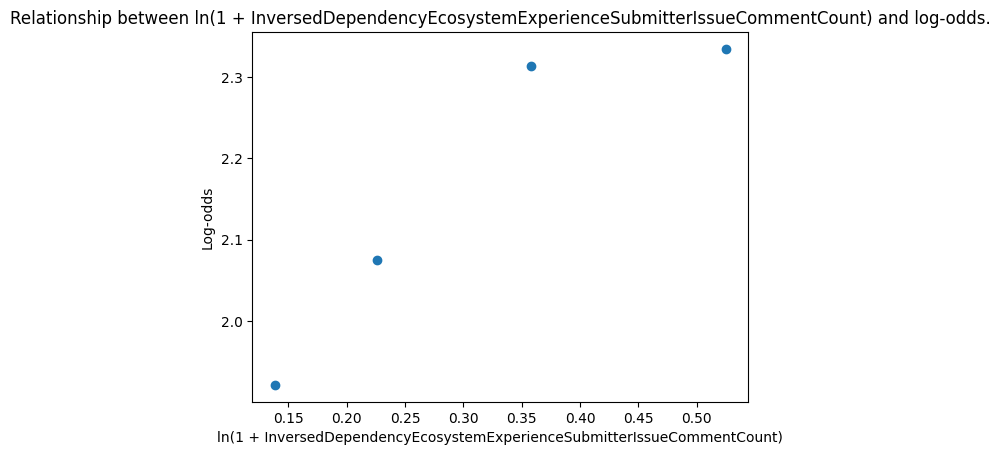

In [4]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame, dependent: pd.Series, transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include="number")

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r".*SuccessRate.*", field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[: -len("SuccessRate")]
            count_field = f"ln(1 + {stripped_field}SubmissionCount)"
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        elif re.match(r".*LinkIntensity.*", field):
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.5, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f"{field}:")
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[
                (included[field] >= r_start) & (included[field] <= r_end)
            ]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f"Skipped {field} because of division by zero.")
            continue

        print(f"{x=}, {y=}")

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = (
            f"{figure_base_path}/log-odds-independence/{transform_title}/{field}"
        )
        safe_save_fig(output_path)


def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include="number")
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field].apply(
                transform
            )
            transformed_independents = scale(transformed_independents, [field])

        test_log_linearity(
            transformed_independents,
            dependent,
            f"{figure_subfolder}/{transform.__name__}",
        )


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value**2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value**3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, figure_subfolder=""
)

## Multicolinearity


### Dropped fields

The following are fields that were dropped to tackle multicollinearity.
The following two subsections: variance inflation factor, and spearman correlation were used to identify the features that were removed.

In [5]:
# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounds
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    # # dep
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",
    # Inv. dep
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",
    # non-dep
    "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)",
    # intra-proj
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
]

print(
    f"Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity."
)

Removing 17 / 28 fields to account for multicollinearity.


In [6]:
# Drops fields.

logit_df = df[independent_fields].drop(multicollinear_fields, axis=1)

print(f"{len(logit_df)=}")
print(f"{len(logit_df.columns)=}")
print(f"{logit_df.columns=}")

len(logit_df)=1216221
len(logit_df.columns)=11
logit_df.columns=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)'],
      dtype='object')


### Variance Inflation Factor

The following identify problematic features using VIF.

In [7]:
# Replaces binary values with numeric variants so VIF can be calculated.

from statsmodels.stats.outliers_influence import variance_inflation_factor

value_mapper = {False: 0, True: 1}

binary_fields = logit_df.select_dtypes(exclude="number")
print(f"{len(binary_fields.columns)=}")
for feature in binary_fields:
    logit_df[feature] = logit_df[feature].replace(value_mapper)

len(binary_fields.columns)=5


In [8]:
# Calculates VIF

vif_df = pd.DataFrame()
vif_df["variable"] = logit_df.columns
vif_df["VIF"] = [
    variance_inflation_factor(logit_df.values, i) for i in range(logit_df.shape[1])
]

print(vif_df)

                                             variable       VIF
0                         ControlIntegratedBySameUser  1.950568
1                       ControlPullRequestHasComments  3.878642
2          ControlPullRequestHasCommentByExternalUser  1.955759
3                      ControlHasHashTagInDescription  1.544997
4                     SubmitterIsFirstTimeContributor  1.828651
5         ln(1 + ControlPullRequestLifeTimeInMinutes)  4.434082
6         ln(1 + ControlNumberOfCommitsInPullRequest)  3.386407
7   ln(1 + DependencyEcosystemExperienceSubmitterP...  1.414732
8   ln(1 + NonDependencyEcosystemExperienceSubmitt...  1.739652
9   ln(1 + InversedDependencyEcosystemExperienceSu...  1.275217
10  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.487441


In [9]:
# Identifies problematic fields, according to VIF.

VIF_THRESHOLD = 5

problematic_vif = vif_df[vif_df["VIF"] >= VIF_THRESHOLD]

print(f"{VIF_THRESHOLD}")
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:\n", problematic_vif)

5
Problematic VIF fields: 0.
Problematic VIF scores:
 Empty DataFrame
Columns: [variable, VIF]
Index: []


### Spearman Correlation

The following calculates the pairwise spearman correlation, to identify what problematic (groups of) features are.

In [10]:
# Calculates Spearman correlation between variables.

import json

corr = logit_df.corr(method="spearman")
coof_threshold = 0.5
print(f"{coof_threshold=}")

correlating_fields = []
for rowIndex, row in corr.iterrows():
    for columnIndex, coof in row.items():
        if columnIndex <= rowIndex:
            continue
        if abs(coof) < coof_threshold:
            continue
        correlating_fields.append([columnIndex, rowIndex, coof])
correlating_fields = [list(entry) for entry in correlating_fields]

print("Correlating pairs:\n", json.dumps(correlating_fields, indent=2))

coof_threshold=0.5
Correlating pairs:
 [
  [
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    0.5018126876524234
  ]
]


In [11]:
# Generates transitive closure of correlating fields;
# i.e., it identifies clusters of correlating features.

from typing import List, Set

transitive_closures: List[Set[str]] = []

# Iterates through all correlating fields.
for field_a, field_b, _ in correlating_fields:
    was_added = False
    # Sees if one of the components is part of a transitive closure.
    for transitive_closure in transitive_closures:
        if field_a in transitive_closure or field_b in transitive_closure:
            was_added = True
            transitive_closure.update((field_a, field_b))
    # Adds new closure if they are not.
    if not was_added:
        new_set = set()
        new_set.update((field_a, field_b))
        transitive_closures.append(new_set)

# Prepares the closures to be printed.
transitive_closures = [sorted(list(closure)) for closure in transitive_closures]

print(
    "Transitive closure of correlating pairs:\n",
    json.dumps(transitive_closures, indent=2),
)

Transitive closure of correlating pairs:
 [
  [
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments"
  ]
]


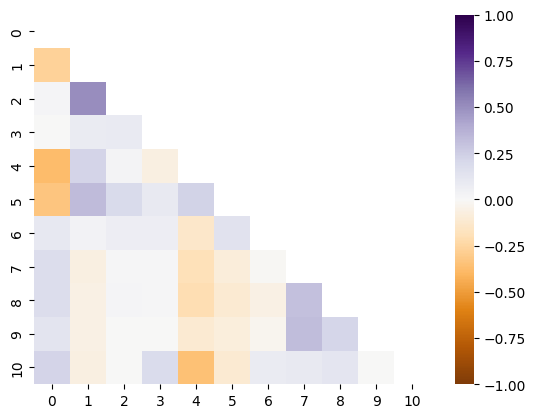

In [12]:
# Plots correlation as seaborn plot.

import seaborn as sb

tick_labels = list(range(len(vif_df)))
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(
    corr,
    cmap="PuOr",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    mask=mask,
    vmin=-1,
    vmax=1,
)

[[0, "ControlIntegratedBySameUser"], [1, "ControlPullRequestHasComments"], [2, "ControlPullRequestHasCommentByExternalUser"], [3, "ControlHasHashTagInDescription"], [4, "SubmitterIsFirstTimeContributor"], [5, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [6, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [7, "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [8, "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [9, "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [10, "ln(1 + IntraProjectSubmitterIssueSubmissionCount)"]]


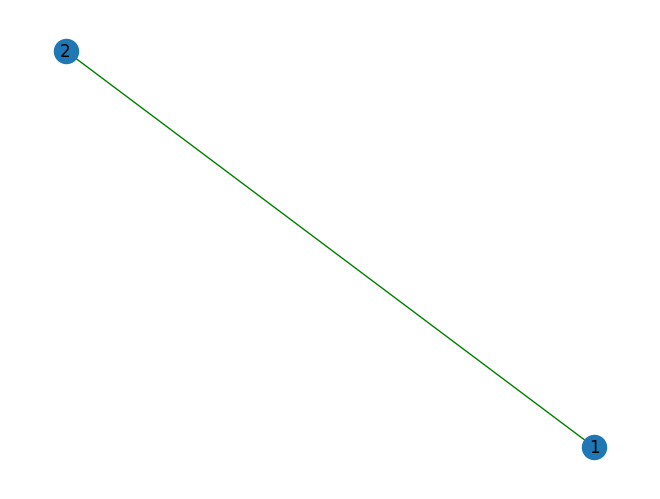

In [13]:
# Plots correlations as a graph.

import networkx as nx
import matplotlib.pyplot as plt

fields = list(logit_df.columns)
enumerated_list = list(enumerate(fields))
ids = []
edge_colors = []
for source, target, coof in correlating_fields:
    source_idx = fields.index(source)
    target_idx = fields.index(target)
    ids.append((source_idx, target_idx))
    edge_colors.append("red" if coof < 0 else "green")

# Create an empty graph
graph = nx.Graph()

# Add edges to the graph from the list of tuples
graph.add_edges_from(ids)

pos = nx.spring_layout(graph, k=0.4)
nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

if len(correlating_fields) == 0:
    print("When there are no correlating fields, the figure is supposed to be empty.")

output_path = f"{figure_base_path}/correlating_fields.png"
safe_save_fig(output_path)

print(json.dumps(enumerated_list))

## Outliers

Using cook's distance.


In [14]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(logit_df)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(
    df[pr_merged_key], X_constant, family=sm.families.Binomial()
).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[["cooks_d"]]

# Set Cook's distance threshold
cook_threshold = 4 / len(logit_df)

# Append absolute standardized residual values
diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[
    (diagnosis_df["cooks_d"] > cook_threshold) & (diagnosis_df["std_resid"] > 3)
]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)

/tmp/ipykernel_102381/2984006829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)


/tmp/ipykernel_102381/2984006829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))


,cooks_d,std_resid
871138,0.000121,29.001423
871029,0.000118,26.408047
870783,0.000118,26.286964
1014730,0.000116,5.820313
1061796,0.000114,12.995367
1061701,0.000113,14.771345
1061747,0.000112,13.507981
870836,0.000111,25.432107
1061866,0.000111,16.546832
1062535,0.000110,5.907150


cook_threshold=3.288908403078747e-06
Found outliers: 22318 / 1216221 (1.835%)


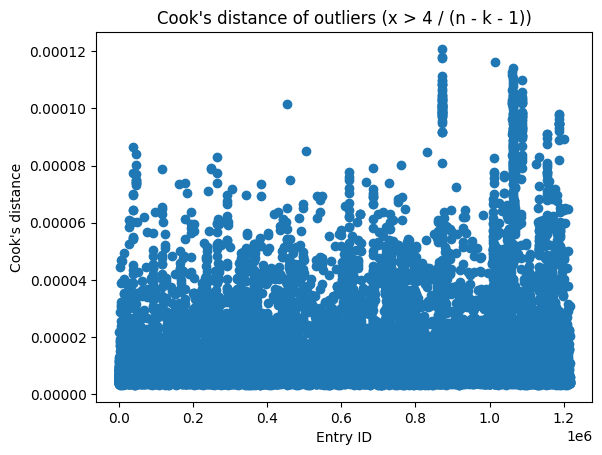

In [15]:
cook_threshold = 4 / (len(logit_df) - len(logit_df.columns) - 1)
print(f'{cook_threshold=}')
print(
    f"Found outliers: {len(extreme)} / {len(logit_df)} ({100 * len(extreme)/len(logit_df):.03f}%)"
)

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme["cooks_d"])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f"{figure_base_path}/cooks_outliers.png"
safe_save_fig(output_path)

Removes outliers

In [16]:
logit_df = logit_df.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f"{len(logit_df)=}")

len(logit_df)=1193903


# Model Creation

Creates a simple mixed effect logistic regression model.

In [17]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[logit_df.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    logit_df,
    tested_projects,
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     1193903                     Method:                                 REML               
No. Groups:                           20051                       Scale:                                  0.1065             
Min. group size:                      1                           Log-Likelihood:                         -414215.2829       
Max. group size:                      688                         Converged:                              Yes                
Mean group size:                      59.5                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
ControlIntegratedBySameUser                                                      -0.261    0.001 -324.624 0.000 -0.262 -0.259
ControlPullRequestHasComments                                                    -0.127    0.001 -151.552 0.000 -0.129 -0.126
ControlPullRequestHasCommentByExternalUser                                        0.030    0.001   34.007 0.000  0.028  0.032
ControlHasHashTagInDescription                                                    0.037    0.001   52.272 0.000  0.036  0.039
SubmitterIsFirstTimeContributor                                                  -0.129    0.001 -159.794 0.000 -0.131 -0.128
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.478    0.002 -289.212 0.000 -0.482 -0.475
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.186    0.005   39.935 0.000  0.177  0.195
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)          0.128    0.005   27.346 0.000  0.119  0.137
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)       0.215    0.002   96.014 0.000  0.211  0.220
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)  0.097    0.006   16.566 0.000  0.085  0.108
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                 0.274    0.003   84.522 0.000  0.268  0.281
Group Var                                                                         1.379    0.044                             
=============================================================================================================================

"""

###

In [18]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f"Dependency Model: {field}"] = fields[field]

dir_name = f"{base_path}/coefs/{file_name}/{experiment_name}"
output_path = f"{dir_name}/coefs.csv"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

output.to_csv(output_path)

In [19]:
import datetime

print(datetime.datetime.now())

2024-02-21 16:52:48.789524
